In [1]:
import pandas as pd
import requests
import json
import os.path
import numpy as np
import matplotlib.pyplot as plt
import pprint
import networkx as nx
import random as rnd

from matplotlib import colors as mcolors
from geopy.distance import geodesic
from pandas.io.json import json_normalize
kkk=0

In [2]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

kkk+=1;print("ordem",kkk)

('ordem', 1)


In [3]:
# Cesar para ver como faz a query consulte https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL
#
#
def getRodovias():
    poly = "-3.070145 -41.397623 -3.378076 -41.529317 -4.200684 -41.243993 -4.890447 -41.353599 -5.284097 -41.045815 -6.630547 -40.878812 -6.915577 -40.558076 -7.360932 -40.566191 -7.453001 -39.765866 -7.952970 -39.061235 -7.934419 -39.033309 -7.331740 -38.439331 -6.841795 -38.603392 -6.139325 -38.365410 -5.758917 -37.974206 -5.007089 -37.536193 -4.780404 -37.074409 -3.680291 -38.287696 -2.704505 -39.959576 -2.725466 -41.413189 -3.043958 -41.382122"
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = '[out:json];'
    overpass_query = overpass_query + 'area[admin_level=2];'
    overpass_query = overpass_query + '('
    overpass_query = overpass_query + 'way["ref"~"^BR-"](poly:"'+str(poly)+'");'
    overpass_query = overpass_query + 'node(w);'
    overpass_query = overpass_query + 'way["ref"~"^CE-"](poly:"'+str(poly)+'");'
    overpass_query = overpass_query + 'node(w);'
    overpass_query = overpass_query + ');'
    overpass_query = overpass_query + 'out center;'
    response = requests.get(overpass_url, params={'data': overpass_query})
    data = response.json()
    return data
kkk+=1;print("ordem",kkk)

('ordem', 2)


In [4]:
#
# Get OSM Data
#
f = "data/data.json"
if(os.path.exists(f)):
    with open(f) as json_file:
        data = json.load(json_file)
else:
    data = getRodovias()
    with open(f, 'w') as fileo:
        json.dump(data, fileo)
        
kkk+=1;print("ordem",kkk)

('ordem', 3)


In [5]:
#
# Create Graph
#
def createG(data):
    G = nx.Graph()
    for element in data['elements']:
        if element['type'] == 'node':
            idn = element['id']
            lon = element['lon']
            lat = element['lat']
            G.add_node(idn,lat=lat,lon=lon,pos=(lon,lat),
                       cidade=0, nomeCidade="",visited=0)
    
    pos = nx.get_node_attributes(G,'pos')
    for element in data['elements']:
        ide = element['id']
        try:
            nodes = element['nodes']
        except:
            nodes = []
        lenNodes = len(nodes)
        if(lenNodes>0):
            #print(element)
            try:
                ref = element['tags']['ref']
            except:
                ref=""
            try:
                name = element['tags']['name']
            except:
                name = ""
                
            #print(ref,name)
                
            for i in range(1,lenNodes):
                lon0,lat0 = pos[nodes[i]]
                lon1,lat1 = pos[nodes[i-1]]
                distance = geodesic((lat0,lon0),(lat1,lon1)).meters
                G.add_edge(nodes[i],nodes[i-1],
                           name=name,
                           ref=ref,
                           distance=distance)
    
    return G

G = createG(data)

kkk+=1;print("ordem",kkk)

('ordem', 4)


In [6]:
def plot1():
    pos = nx.get_node_attributes(G,'pos')
    draw = nx.draw_networkx_nodes(G,pos=pos,node_size=0.01)
    draw = nx.draw_networkx_edges(G,pos=pos,width=1)
    plt.savefig("export/ceara-ce-br.pdf")

kkk+=1;print("ordem",kkk)

('ordem', 5)


In [7]:
cc = sorted(nx.connected_components(G), key = len, reverse=True)
pos = nx.get_node_attributes(G,'pos')
def plot2():
    lcc = list(cc[0])
    sorted_names = sorted_names + sorted_names
    pos = nx.get_node_attributes(G,'pos')
    for i in range(len(cc)):
        #if(i==len(sorted_names)): break
        if(len(cc[i])<=100):
            color = sorted_names[i]
            draw = nx.draw_networkx_nodes(G,pos=pos,node_size=0.05,nodelist=list(cc[i]),node_color=color)
    plt.savefig("export/ceara-ce-br-subG-le100.pdf")

kkk+=1;print("ordem",kkk)

('ordem', 6)


In [8]:
nx.write_gml(G,'export/G.gml')

kkk+=1;print("ordem",kkk)

('ordem', 7)


In [9]:
def checkNodeNeig():
    dfcid = pd.read_csv("data/Municipios-Brasileiros/csv/municipios.csv",delimiter=",")
    dfcid["distancia"] = 1e10
    dfcid["node"] = 1

    # Ceará (23)
    dfcid = dfcid[dfcid.codigo_uf == 23]

    for i in dfcid.index:
        minV = dfcid.distancia.loc[i]
        lat0 = dfcid.latitude.loc[i]
        lon0 = dfcid.longitude.loc[i]
        cidade = dfcid.nome.loc[i]

        for n in list(G.nodes()):
            lon1,lat1 = pos[n]
            v = geodesic((lat0,lon0),(lat1,lon1)).meters
            if(v <= minV): 
                minV = v
                minN = n

        dfcid.distancia.at[i] = minV
        dfcid.node.at[i] = minN
        #print(cidade,minV,minN)

#
# Cria o arquivo de cidades mais proximo ao um vértice
#
try:
    dfcid = pd.read_pickle("data/cidades.plk")
except:
    print("Preciso criar o arquivo")
kkk+=1;print("ordem",kkk)

('ordem', 8)


In [10]:
#
# Update Cities into Graph
#

def plot3(dfcid,pos):
    draw = nx.draw_networkx_nodes(G,pos=pos,node_size=0.01)
    draw = nx.draw_networkx_nodes(G,pos=pos,nodelist=list(dfcid.node),node_size=5,node_color="blue")

    plt.savefig("export/ceara-ce-br-with-city.pdf")
#plot3(dfcid,pos)

cidades = nx.get_node_attributes(G,'cidade')
nome_cidades = nx.get_node_attributes(G,'nomeCidade')

for i in dfcid.index:
    cidade = dfcid.nome.loc[i]
    node = dfcid.node.loc[i]
    
    cidades[node] = 1
    nome_cidades[node] = cidade
    
nx.set_node_attributes(G,cidades,'cidade')
nx.set_node_attributes(G,nome_cidades,'nomeCidade') 

nodesCidades = list(dfcid.node)

nx.write_gml(G,'export/G.gml')


kkk+=1;print("ordem",kkk)

('ordem', 9)


In [37]:
#
# Connect the endpoint between subgraphs
#
minsV = np.load("data/minsV.npy")
nodesMin = np.load("data/nodesMin.npy")

G1 = G.copy()

nodesMinA = (nodesMin.item())
k=0
joinList = []
for i in range(166):
    for j in range(166):
        v = minsV[i,j]
        if(v<=10000):
            k+=1
            joinList.append(nodesMinA[i,j][0])
            joinList.append(nodesMinA[i,j][1])
            neig0 = list(G1.neighbors(nodesMinA[i,j][0]))
            namea = G1[nodesMinA[i,j][0]][neig0[0]]["name"]
            refa = G1[nodesMinA[i,j][0]][neig0[0]]["ref"]
            G1.add_edge(nodesMinA[i,j][0],nodesMinA[i,j][1],
                        distance=v,ref=refa,name=namea,ide="join")
            #print(i,j,v)
cc1 = sorted(nx.connected_components(G1), key = len, reverse=True)
print("subG",len(cc1))
print(k,166*166)

kkk+=1;print("ordem",kkk)


('subG', 8)
(389, 27556)
('ordem', 25)


In [38]:
#
# Clear nodes not necessary 
#
def clearGraph(G,forbidem):

    G1 = G.copy()
    nodes = G.nodes()
    
    dist = nx.get_edge_attributes(G,'distance')
    name = nx.get_edge_attributes(G,'name')
    ref = nx.get_edge_attributes(G,'ref')
    
    removeNodes = []
    removeEdges = []
    
    k=0
    l=0
    for n in nodes:
        
        if(n not in forbidem):
            
            deg = G1.degree(n)
            if(deg == 0):
                removeNodes.append(n)
                k+=1
            elif(deg == 1):
                #
                # Not needs remove
                #
                neig = list(G1.neighbors(n))
                back = neig[0]
                try:
                    dist1 = dist[n,back]
                except:
                    try:
                        dist1 = dist[back,n]
                    except:
                        dist1 = 0
                
                #removeNodes.append(n)
                #removeEdges.append((n,back))
                
            elif(deg == 2):
                neig = list(G1.neighbors(n))
                back = neig[0]
                forw = neig[1]

                try:
                    dist1 = dist[n,back]
                except:
                    try:
                        dist1 = dist[back,n]
                    except:
                        dist1 = 0
                        print(n,back)

                try:
                    dist2 = dist[n,forw]
                except:
                    try:
                        dist2 = dist[forw,n]
                    except:
                        dist2 = 0
                        print(n,forw)

                try:
                    name1 = name[n,back]
                except:
                    try:
                        name1 = name[back,n]
                    except:
                        name1 = 0
                        
                try:
                    ref1 = ref[n,back]
                except:
                    try:
                        ref1 = ref[back,n]
                    except:
                        ref1 = 0
                        
                if(back != forw and dist1 > 0 and dist2 > 0):
                    G1.add_edge(back,forw,
                               distance=dist1+dist2,
                               name=name1,
                               ref=ref1)

                    removeNodes.append(n)
                    removeEdges.append((n,back))
                    removeEdges.append((n,forw))

    for n1,n2 in removeEdges:
        try: G1.remove_edge((n1,n2))
        except: pass
        l+=1
     
    for n in removeNodes:
        try: G1.remove_node(n)
        except: pass
        k+=1
    
    print("# "+str(k)+" nodes and "+str(l)+" edges removed")
    return G1,k

G2,k = clearGraph(G1,nodesCidades)
while(k>1):
    G2,k = clearGraph(G2,nodesCidades)

(4120554258, 4753834471)
(4887683746, 5264425880)
(4307559270, 4307559239)
(1189882900, 6215056304)
(1781280604, 2019296159)
(1802252877, 1802252871)
(3225439201, 2515288987)
(628643685, 3933179607)
(5060210944, 4136519602)
(4942772314, 4942772312)
(2109784133, 6258494468)
(4214454258, 4214454242)
(2348081923, 2348081917)
(2441706670, 2441706669)
(5122785054, 4437889495)
(4076929637, 4076929639)
(1739133291, 2515581120)
(1739134100, 1739134097)
(1964579703, 1964579701)
(4331287139, 4331287133)
(3687396843, 3687396847)
(4235539993, 4932419099)
(4747248354, 3789451158)
(1663388788, 3850553067)
(4119419327, 5289614153)
(3797251715, 5197203636)
(2752874125, 2752874058)
(2395310069, 2395310067)
(5661625220, 5661625229)
(2943454531, 2943454529)
(4942480574, 4753742844)
(1430364703, 5043548766)
(2078645005, 2078644992)
(4911120522, 2206467439)
(4236353912, 4236353904)
(1691736126, 1691735664)
(4120500754, 4120500755)
(4463910136, 4762531050)
(3836527132, 2401651578)
(4236355388, 4236355386)
(

(4911120522, 4911120536)
(3992931058, 2138750025)
(3558197461, 5278491086)
(3103510362, 2014773389)
(1691736126, 1691735681)
(4120500754, 4120500759)
(4463910136, 4463874174)
(1697636821, 1697636201)
(1520166405, 1520166400)
(263973493, 3921666696)
(4462629626, 4462629617)
(1502083807, 2519032490)
# 7689 nodes and 15378 edges removed
(3841709477, 3841709472)
(4217080355, 4217080338)
(5043556897, 5043556892)
(351933508, 1647744657)
(1908905391, 1908905395)
(5055846544, 5055846414)
(263986677, 5906596387)
(3036552847, 1701754361)
(4236353912, 4236354520)
(1805362253, 1805362176)
(4236355388, 4236355356)
(3799853585, 4441019969)
(351973490, 850730861)
(4752126206, 4752115183)
(4932645232, 4521450986)
(263986679, 5906595938)
(2987144469, 2516185154)
(3687396843, 3687411198)
(1644388054, 3798386770)
(4124931206, 4381120773)
(4458200665, 3016657453)
(4453482077, 4453482071)
(2514537061, 4331332485)
(2109784133, 3787923166)
(2330870264, 2330870277)
(5910252305, 4753562551)
(4747248354, 251618

8
('ordem', 26)


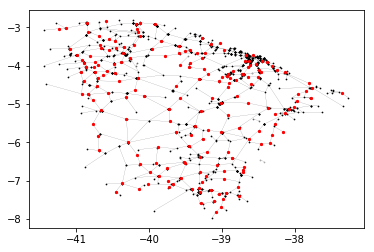

In [39]:
def plot5(sorted_names,nodesCidades):
    cc1 = sorted(nx.connected_components(G2), key = len, reverse=True)
    print(len(cc1))
    pos1 = nx.get_node_attributes(G2,'pos')
    sorted_names = sorted_names + sorted_names
    for i in range(len(cc1)):
        color = sorted_names[i]
        draw = nx.draw_networkx_nodes(G2,pos=pos1,node_size=0.5,nodelist=list(cc1[i]),node_color=color)
    draw = nx.draw_networkx_nodes(G2,pos=pos1,nodelist=nodesCidades,node_size=5)
    draw = nx.draw_networkx_edges(G2,pos=pos1,width=0.1)
    plt.savefig("export/ceara-ce-br-filtered.pdf")
plot5(sorted_names,nodesCidades)
kkk+=1;print("ordem",kkk)

In [40]:
nx.write_gml(G2,'export/G2.gml')
print(G2.number_of_nodes())

1610


In [41]:
#
# Verifica sítios proximos
#
def checkAgreg(G3):
    
    nodesA = G3.nodes()
    nodes = nodesA.keys()
    lenG = len(nodes)
    minsV = np.zeros((lenG,lenG))
    nodesMinU = np.zeros((lenG,lenG))
    nodesMinV = np.zeros((lenG,lenG))
    minsV = minsV + 1e10
    k=0
    for i in range(lenG):
        ni = nodes[i]
        lon0, lat0 = (nodesA[ni]["lon"],nodesA[ni]["lat"])
        for j in range(i+1,lenG):
            nj = nodes[j]
            lon1, lat1 = (nodesA[nj]["lon"],nodesA[nj]["lat"])
            minv = minsV[i,j]
            v = geodesic((lat0,lon0),(lat1,lon1)).meters
            #print(k,i,ni,j,nj,minv,v)
            if(v<minv): 
                minsV[i,j] = v
                nodesMinU[i,j] = ni
                nodesMinV[i,j] = nj
                    #if(k>100): return
                k+=1
    return minsV, nodesMinU, nodesMinV

try:
    minsV2 = np.load("data/minsV2-3.npy")
    nodesMinU2 = np.load("data/nodesMinU2-3.npy")
    nodesMinV2 = np.load("data/nodesMinV2-3.npy")
except:
    print("Precisa criar o arquivo")
    minsV2, nodesMinU2, nodesMinV2 = checkAgreg(G2)
    np.save("data/minsV2-3.npy",minsV2)
    np.save("data/nodesMinU2-3.npy",nodesMinU2)
    np.save("data/nodesMinV2-3.npy",nodesMinV2)

In [42]:
lenG = G2.number_of_nodes()
minV3 = {}
visited = []

def linkedList(n,minV3,visited):
    minV3[n] = []
    visited.append(n)
    for i in range(lenG): 
        v = minsV2[n,i]
        if(v<=500):
            if(i not in visited):
                minV3[n].append(i)
    for j in minV3[n]:
        minV3,visited = linkedList(j,minV3,visited)
            
    return minV3,visited

for i in range(lenG):
    minV3,visited = linkedList(i,minV3,visited)
    
kkk+=1;print("ordem",kkk)

('ordem', 27)


In [43]:
group = {}
visited2 = []

def agregate(n,visited2,tgroup,tng,nodesMinU2,nodesMinV2):
    visited2.append(n)
    neig = minV3[n]
    for i in neig:
        tgroup.append(i)
        tng.append((int(nodesMinU2[n,i]),int(nodesMinV2[n,i])))
        visited2, tgroup, tng = agregate(i,visited2,tgroup,tng,nodesMinU2,nodesMinV2)
    return visited2, tgroup, tng

nodesA = G2.nodes()
nodes = nodesA.keys()
nodesG = {}
for i in range(lenG):
    group[i] = []
    nodesG[nodes[i]] = []
    visited2, group[i],nodesG[nodes[i]] = agregate(i,visited2,group[i],nodesG[nodes[i]],nodesMinU2,nodesMinV2)

    
kkk+=1;print("ordem",kkk)

('ordem', 28)


In [44]:
def agregateNodes(G3,node,removeNodes,removeEdges,dism=1000):
    G3.nodes[node]["visited"]=-1
    nodes = G3.nodes()
    pos = nx.get_node_attributes(G3,'pos')
    lon0, lat0 = pos[node]
    neig = list(G3.neighbors(node))
    for nd in neig:
        if(G3.nodes[nd]["visited"]==0):
            lon1, lat1 = pos[nd]
            v = geodesic((lat0,lon0),(lat1,lon1)).meters
            if(v<dism and G3.nodes[nd]["cidade"]==0):
                neig2 = list(G3.neighbors(nd))
                
                try: 
                    neig2.remove(node)
                except:
                    pass
                
                for nd2 in neig2:
                    if(nd2 not in neig): neig.append(nd2)
                    dista = G3[nd][nd2]["distance"]
                    namea = G3[nd][nd2]["name"]
                    refa = G3[nd][nd2]["ref"]
                    G3.add_edge(node,nd2,distance=dista+v,name=namea,ref=refa)
                
                removeEdges.append((node,nd))
                removeNodes.append(nd)
                #print("#",nd)
            else:
                removeNodes,removeEdges = agregateNodes(G3,nd,removeNodes,removeEdges,dism)
            #print(nd,neig)
    return removeNodes,removeEdges


G4 = G2.copy()

rnd.seed(1000)
for i in range(100):
    print("******",i)
    removeNodes = []
    removeEdges = []
    nodes = G4.nodes()
    
    nod = nodes.keys()
    visited = nx.get_node_attributes(G4,'visited')

    idn = int(rnd.random()*len(nodes))

    for i in visited:
        visited[i]=0
    nx.set_node_attributes(G4,visited,'visited')

    removeNodes,removeEdges = agregateNodes(G4,nod[idn],removeNodes,removeEdges,1000)
    
    for u,v in removeEdges:
        try:
            G4.remove_edge(u,v)
        except:
            pass
    
    for n in removeNodes:
        try:
            G4.remove_node(n)
        except:
            pass
    
    G4,k = clearGraph(G4,nodesCidades)
    while(k>1):
        G4,k = clearGraph(G4,nodesCidades)

kkk+=1;print("ordem",kkk)


('******', 0)
(6045149443, 4896031177)
(3225439201, 1656132612)
(5043556897, 3168611116)
(1650365720, 2970041708)
(3699210454, 353023651)
(264898958, 263341753)
(1544781214, 5916346180)
(4962893727, 3977917307)
# 93 nodes and 142 edges removed
# 12 nodes and 24 edges removed
# 2 nodes and 4 edges removed
# 1 nodes and 2 edges removed
('******', 1)
# 8 nodes and 16 edges removed
# 0 nodes and 0 edges removed
('******', 2)
# 2 nodes and 4 edges removed
# 0 nodes and 0 edges removed
('******', 3)
# 0 nodes and 0 edges removed
('******', 4)
# 0 nodes and 0 edges removed
('******', 5)
# 0 nodes and 0 edges removed
('******', 6)
# 0 nodes and 0 edges removed
('******', 7)
# 0 nodes and 0 edges removed
('******', 8)
# 0 nodes and 0 edges removed
('******', 9)
# 0 nodes and 0 edges removed
('******', 10)
# 0 nodes and 0 edges removed
('******', 11)
# 0 nodes and 0 edges removed
('******', 12)
# 0 nodes and 0 edges removed
('******', 13)
# 0 nodes and 0 edges removed
('******', 14)
# 0 nodes an

('ordem', 30)


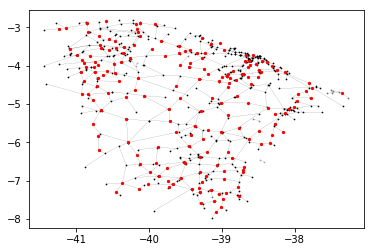

In [45]:
def plot6(G1,sorted_names,nodesList=""):
    cc1 = sorted(nx.connected_components(G1), key = len, reverse=True)
    names = nx.get_node_attributes(G1, 'nomeCidade')
    pos1 = nx.get_node_attributes(G1,'pos')
    sorted_names = sorted_names + sorted_names
    for i in range(len(cc1)):
        color = sorted_names[i]
        draw = nx.draw_networkx_nodes(G1,pos=pos1,
                                      node_size=0.5,
                                      nodelist=list(cc1[i]),
                                      node_color=color)
        #dra = nx.draw(G1,pos=pos1,label=names,node_size=0.5)
    if(len(nodesList)>0):
        draw = nx.draw_networkx_nodes(G1,pos=pos1,nodelist=nodesList,node_size=5,color="red")
    draw = nx.draw_networkx_edges(G1,pos=pos1,width=0.1)
    plt.savefig("export/ceara-ce-br-filtered.pdf")
#plot6(G3,sorted_names,nodesCidades)
kkk+=1;print("ordem",kkk)

plot6(G4,sorted_names,nodesCidades)


In [46]:
print(G4.number_of_nodes())

697


In [54]:
edges = G4.edges(data=True)
nodes = G4.nodes(data=True)

In [73]:
f = open("export/nodes.csv","w")
f.write("node;lat;lon;cidade;nomeCidade\n")
for n, prop in nodes:
    f.write(str(n)+";"
            +str(prop["lat"])+";"
            +str(prop["lon"])+";"
            +str(prop["cidade"])+";"
            +str(prop["nomeCidade"])+"\n")
f.close()

In [74]:
f = open("export/edges.csv","w")
f.write("node0;node1;ref;name;distance\n")
for u,v, prop in edges:
    ref = prop["ref"]
    name = prop["name"].encode('utf8')
    f.write(str(u)+";"
            +str(v)+";"
            +str(ref)+";"
            +str(name)+";"
            +str(prop["distance"])+"\n")
f.close()